In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 91% 135M/149M [00:00<00:00, 202MB/s]
100% 149M/149M [00:00<00:00, 190MB/s]


In [ ]:
def get_class_paths(path):
  classes = []
  classpaths = []

  for lable in os.listdir(path):
    lable_path = os.path.join(path ,lable)

    if os.path.isdir(lable_path):

      for image in os.listdir(lable_path):
        image_path = os.path.join(lable_path , image)

        classes.append(lable)
        classpaths.append(image_path)

  df = pd.DataFrame({
      'Class Path' : classpaths,
      'Class' : classes
  })
  return df


In [ ]:
tr_df = get_class_paths('/content/Training')
tr_df

,Class Path,Class
0,/content/Training/glioma/Tr-gl_1248.jpg,glioma
1,/content/Training/glioma/Tr-gl_0416.jpg,glioma
2,/content/Training/glioma/Tr-gl_0619.jpg,glioma
3,/content/Training/glioma/Tr-gl_0329.jpg,glioma
4,/content/Training/glioma/Tr-gl_0055.jpg,glioma
...,...,...
5707,/content/Training/pituitary/Tr-pi_1444.jpg,pituitary
5708,/content/Training/pituitary/Tr-pi_0037.jpg,pituitary
5709,/content/Training/pituitary/Tr-pi_0333.jpg,pituitary
5710,/content/Training/pituitary/Tr-pi_1200.jpg,pituitary


In [ ]:
ts_df = get_class_paths('/content/Testing')
ts_df

,Class Path,Class
0,/content/Testing/glioma/Te-gl_0289.jpg,glioma
1,/content/Testing/glioma/Te-gl_0295.jpg,glioma
2,/content/Testing/glioma/Te-gl_0167.jpg,glioma
3,/content/Testing/glioma/Te-gl_0237.jpg,glioma
4,/content/Testing/glioma/Te-gl_0084.jpg,glioma
...,...,...
1306,/content/Testing/pituitary/Te-pi_0246.jpg,pituitary
1307,/content/Testing/pituitary/Te-pi_0206.jpg,pituitary
1308,/content/Testing/pituitary/Te-pi_0184.jpg,pituitary
1309,/content/Testing/pituitary/Te-pi_0178.jpg,pituitary


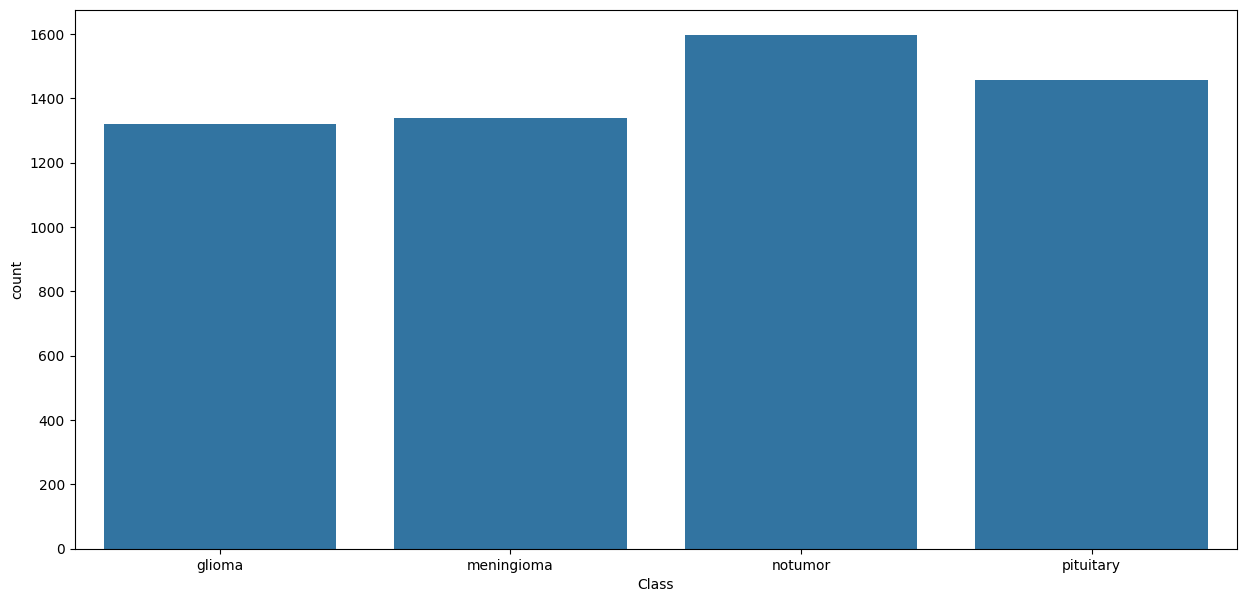

In [ ]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = tr_df , x = tr_df['Class'])

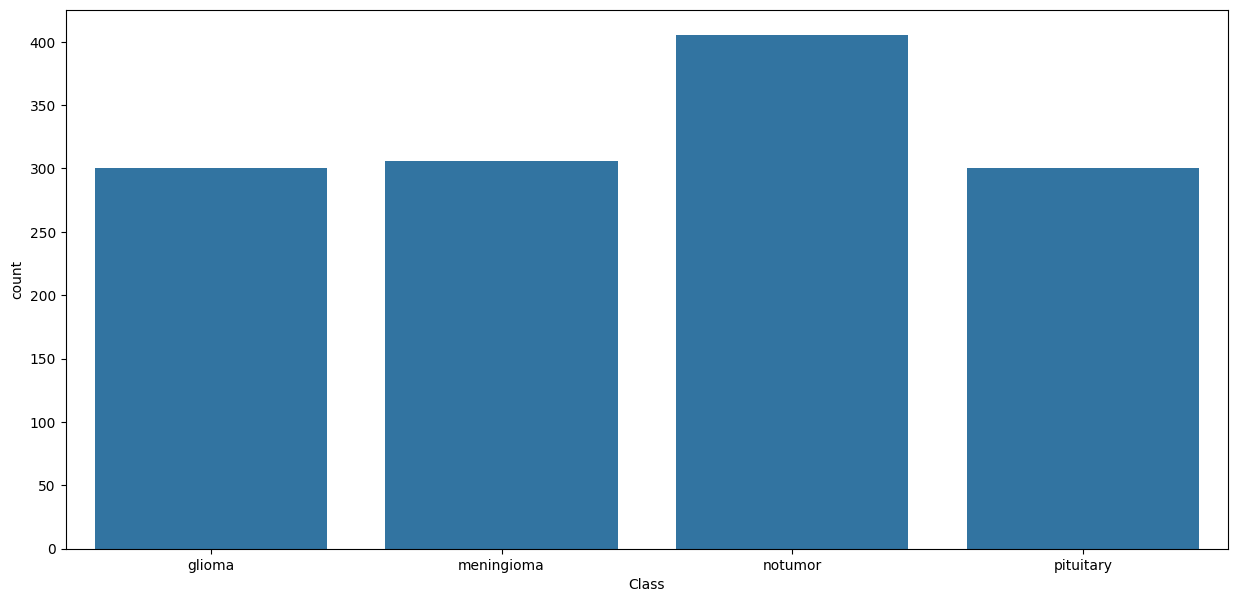

In [ ]:
plt.figure(figsize = (15,7))
ax = sns.countplot(data = ts_df , x = ts_df['Class'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision , Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
valid_df , ts_df = train_test_split(ts_df , train_size=0.5 , stratify=ts_df['Class'])

In [ ]:
batch_size = 32

image_size = (299,299)

image_generator = ImageDataGenerator(rescale = 1/255 , brightness_range = (0.8,1.2))

ts_generator = ImageDataGenerator(rescale = 1/255 )

In [ ]:
tr_gen = image_generator.flow_from_dataframe(
    tr_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

ts_gen = ts_generator.flow_from_dataframe(
    ts_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = 16,
    target_size = image_size, shuffle = False
)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


<function matplotlib.pyplot.show(close=None, block=None)>

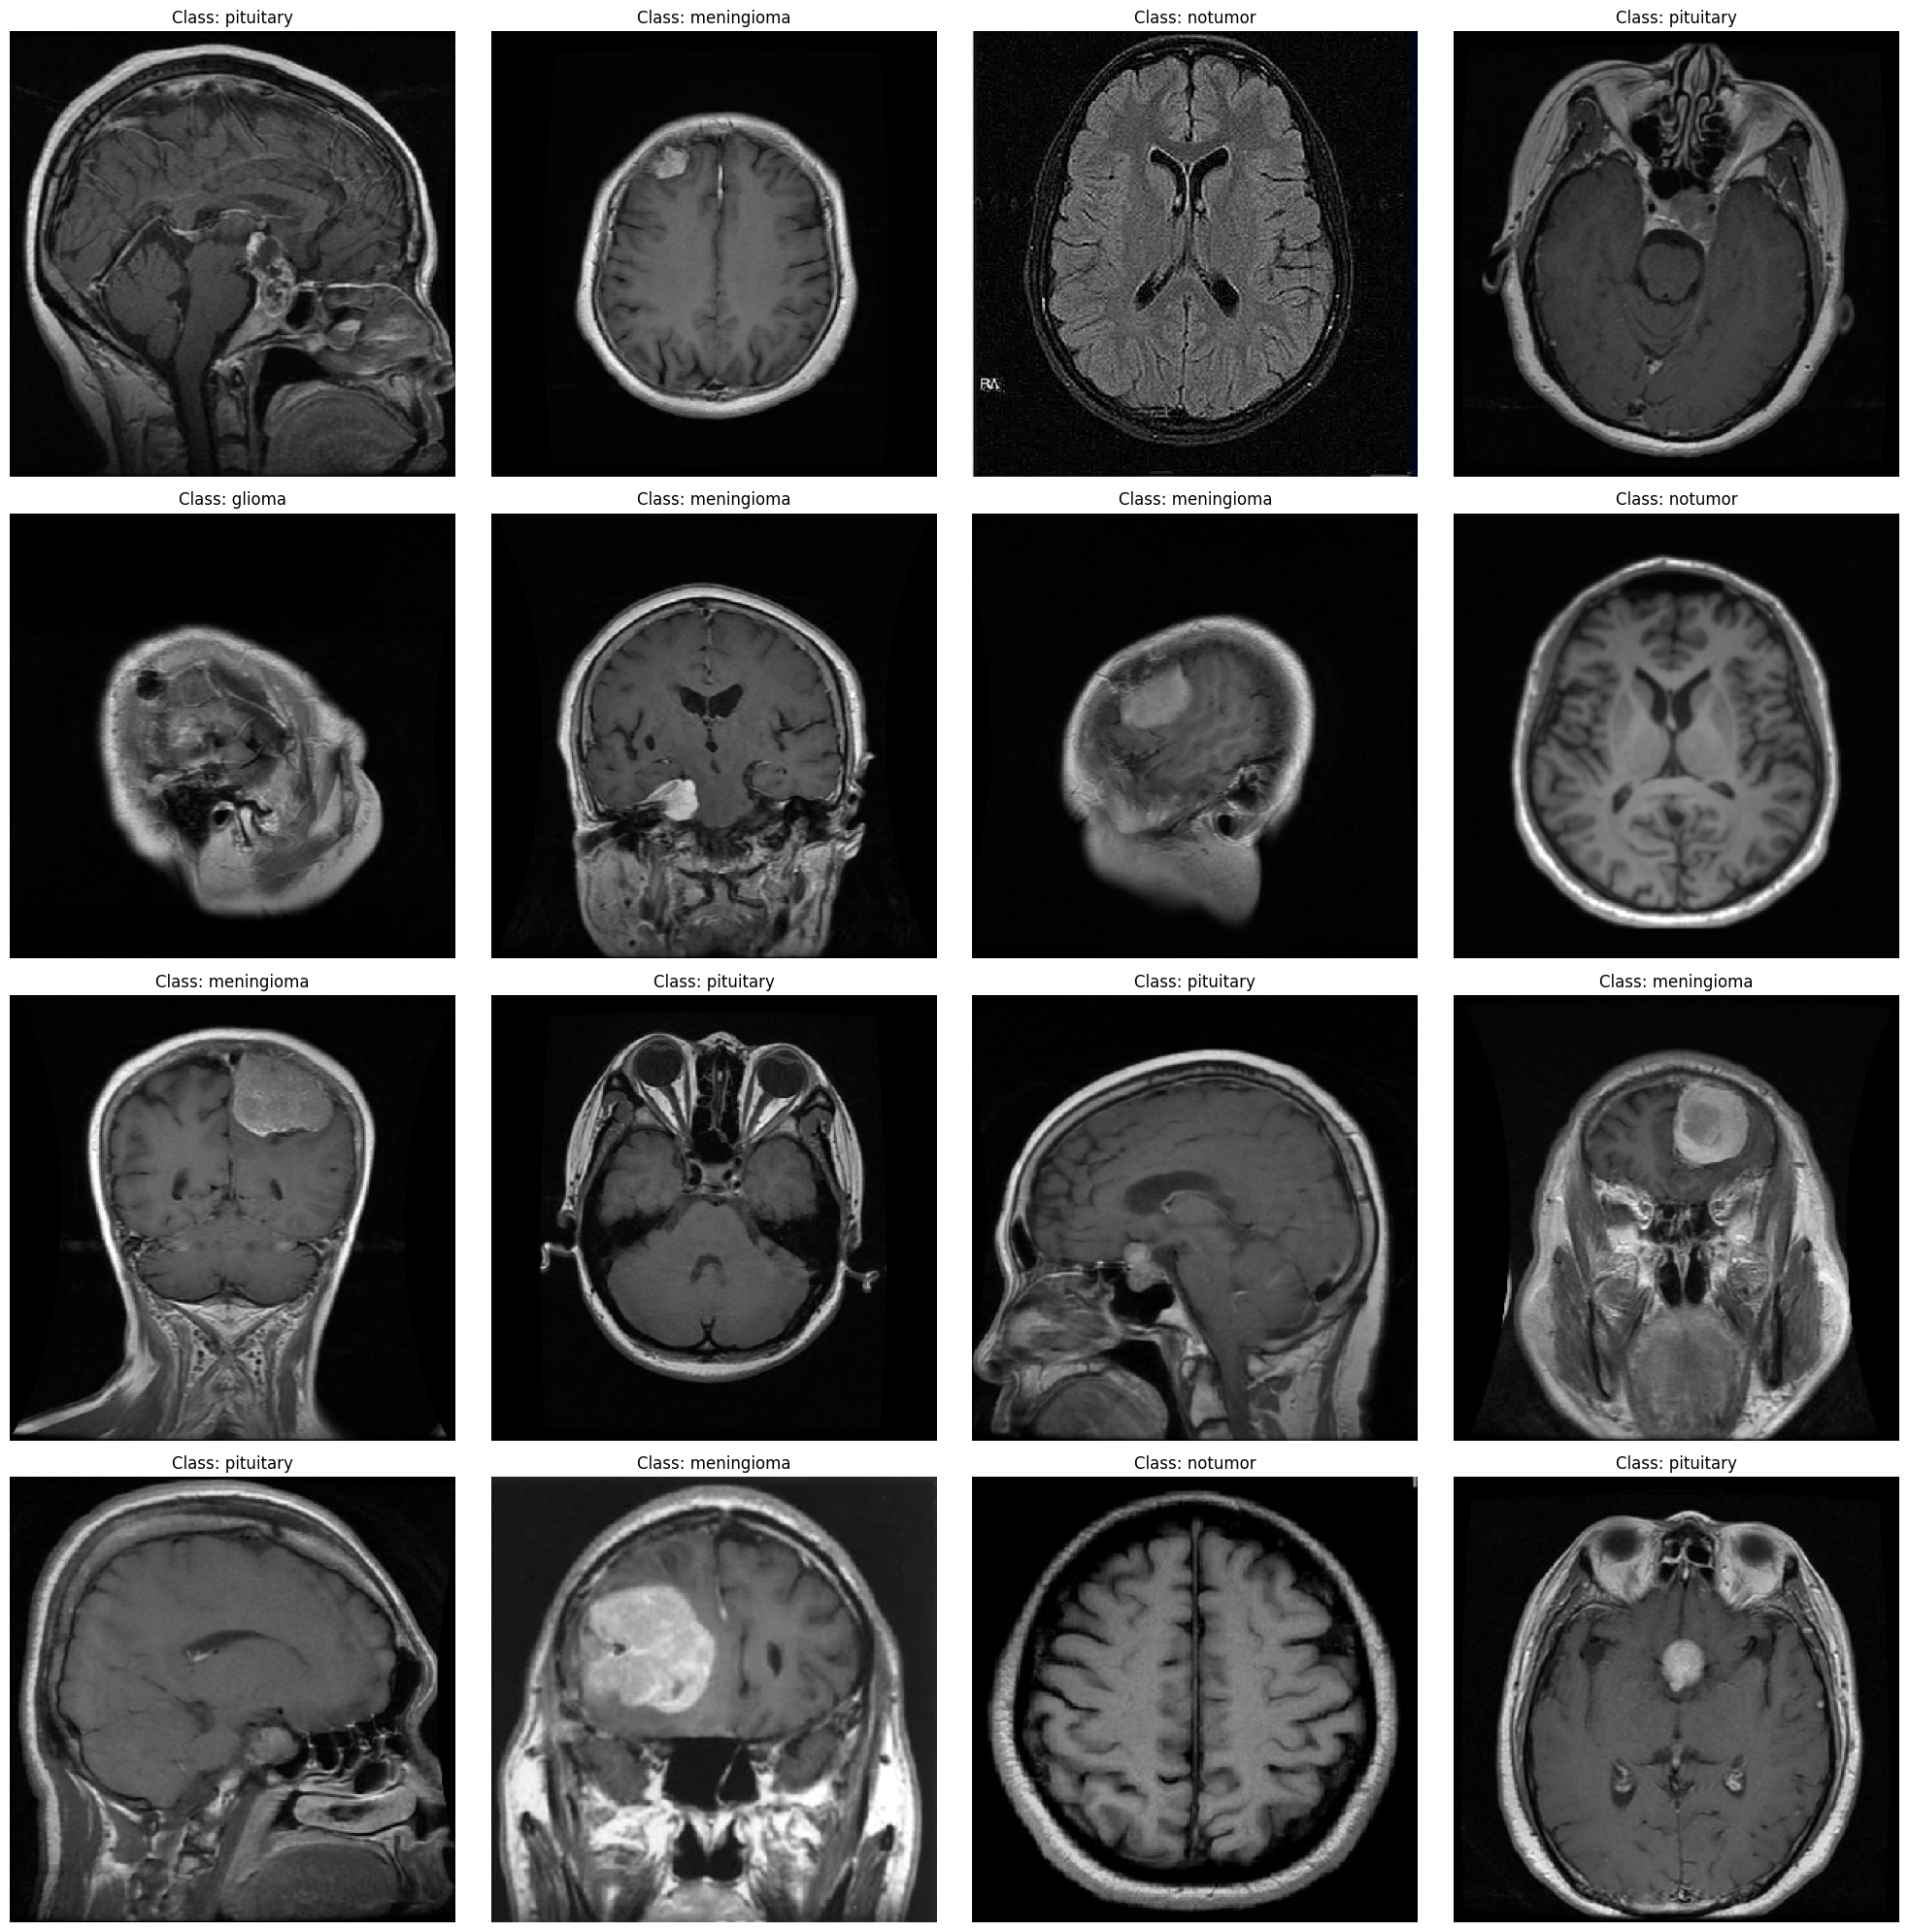

In [ ]:
plt.figure(figsize=(20,20))
for i in range (16):
  plt.subplot(4,4,i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  lable =batch[1][0]
  plt.imshow(image)

  class_index = np.argmax(lable)

  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  index_position = class_indices.index(class_index)

  class_name = class_names[index_position]

  plt.title(f'Class: {class_name}')
  plt.axis('off')

plt.tight_layout()
plt.show

In [ ]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = img_shape,
    pooling = 'max'
)

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate = 0.3),      # used to prevent overfitting
    Dense(128, activation = 'relu'),
    Dropout(rate = 0.25),
    Dense(4, activation = 'softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(Adamax(learning_rate= 0.001),
              loss = 'categorical_crossentropy',
              metrics = [
                  'accuracy',
                  Precision(),
                  Recall()
              ])

In [ ]:
hist = model.fit(
    tr_gen,
    epochs = 5,
    validation_data = valid_gen,)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7630 - loss: 0.7515 - precision: 0.8169 - recall: 0.6524 - val_accuracy: 0.8702 - val_loss: 0.3682 - val_precision: 0.8721 - val_recall: 0.8641
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 876ms/step - accuracy: 0.9771 - loss: 0.0655 - precision: 0.9795 - recall: 0.9765 - val_accuracy: 0.9710 - val_loss: 0.0899 - val_precision: 0.9739 - val_recall: 0.9695
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 162s 899ms/step - accuracy: 0.9934 - loss: 0.0195 - precision: 0.9941 - recall: 0.9932 - val_accuracy: 0.9878 - val_loss: 0.0470 - val_precision: 0.9878 - val_recall: 0.9878
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 871ms/step - accuracy: 0.9942 - loss: 0.0199 - precision: 0.9946 - recall: 0.9942 - val_accuracy: 0.9863 - val_loss: 0.0333 - val_precision: 0.9862 - val_recall: 0.9847
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 867ms/step - accuracy: 0.9980 - loss: 0.0075 - precision: 0.9990 - recall: 0.9980 - val_accuracy: 0.9924 - val_loss: 

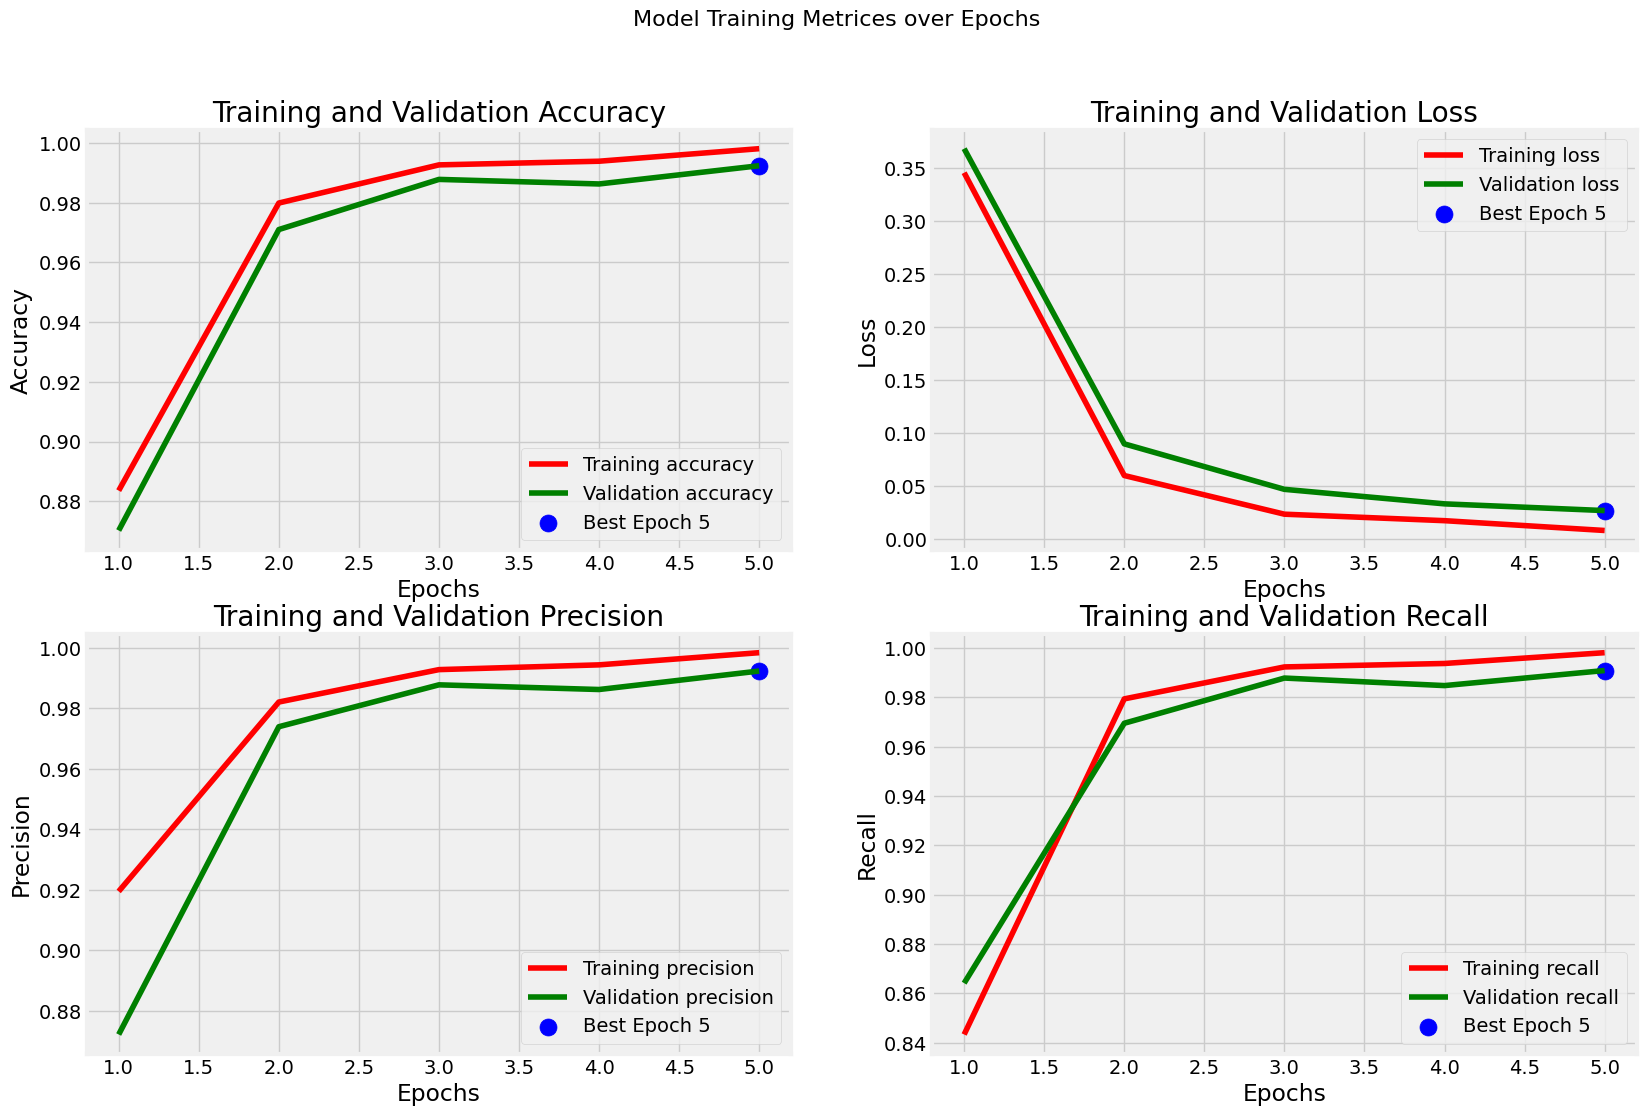

In [ ]:
metrics = ['accuracy' , 'loss' , 'precision' , 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

best_epochs = {}
best_values = {}

for m in metrics:
    if m == 'loss' :
      idx = np.argmin(val_metrics[m])
    else:
      idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx+1
    best_values[m] = val_metrics[m][idx]

plt.figure(figsize = (20,12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics,1):
    plt.subplot(2,2,i)
    epochs = range(1,len(tr_metrics[metric]) +1 )

    plt.plot(epochs , tr_metrics[metric], 'r', label = f'Training {metric}')
    plt.plot(epochs , val_metrics[metric], 'g', label = f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150 , c = 'b',
              label = f'Best Epoch {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Model Training Metrices over Epochs', fontsize = 16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen , verbose = 1)
valid_score = model.evaluate(valid_gen , verbose = 1)
test_score = model.evaluate(ts_gen , verbose = 1)

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 253ms/step - accuracy: 0.9995 - loss: 0.0017 - precision: 0.9995 - recall: 0.9995
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9967 - loss: 0.0102 - precision: 0.9970 - recall: 0.9967
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9375 - loss: 0.4673 - precision: 0.9375 - recall: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9832 - loss: 0.0752 - precision: 0.9869 - recall: 0.9832
Train Accuracy: 99.89%
Train Loss: 0.0026


Validation Accuracy: 99.08%
Validation Loss: 0.0212


Test Accuracy: 98.78%
Test Loss: 0.0535


In [10]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds , axis = 1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituatary'
}

cm = confusion_matrix(ts_gen.classes , y_pred)
labels = list(class_dict.keys())
plt.figure(figsize = (10,8))
sns.heatmap(cm , annot = True, fmt = 'd' , cmap = 'Blues', xticklabels = labels , yticklabels = labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'model' is not defined

In [ ]:
from PIL import Image

def predict(img_path: str) -> None:

  #get class labels
  labels = list(class_dict.keys())

  plt.figure(figsize=(6,8))

  #load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array , axis = 0) /255.0

  #get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict[ predicted_class_idx]

  #plot original image
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f'Input MRI Image/nPredicted: {predicted_class}')

  #plot prediction probabilites
  plt.subplot(2,1,2)
  bars = plt.barh(labels , probabilities)
  plt.xlabel('Probabilites', fontsize = 15)
  plt.title('Class Probabilities')

  #add probability labels to bar
  ax = plt.gca()
  ax.bar_label(bars , fmt='%.2f')

  plt.tight_layout()
  plt.show()

  print(f'Predicted Tumour type: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


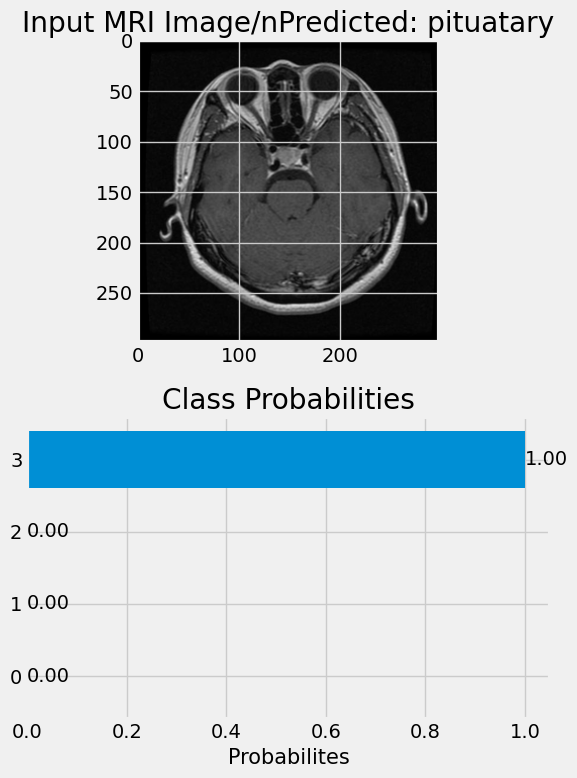

Predicted Tumour type: pituatary


In [ ]:
predict("/content/Testing/pituitary/Te-pi_0011.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

In [ ]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

In [ ]:
batch_size = 16
image_size = (224, 224)

image_generator = ImageDataGenerator(rescale = 1/255 , brightness_range = (0.8,1.2))
ts_generator = ImageDataGenerator(rescale = 1/255 )

tr_gen = image_generator.flow_from_dataframe(
    tr_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

valid_gen = image_generator.flow_from_dataframe(
    valid_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = batch_size,
    target_size = image_size
)

ts_gen = ts_generator.flow_from_dataframe(
    ts_df , x_col = 'Class Path',
    y_col = 'Class', batch_size = 16,
    target_size = image_size, shuffle = False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
# Create a Sequential model
cnn_model = Sequential()

# Convolution layers with Batch Normalization
cnn_model.add(Conv2D(512, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

# Output layer
cnn_model.add(Dense(4, activation='softmax'))

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics =['accuracy', Precision(), Recall()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(
    tr_gen ,
    epochs = 10 ,
    validation_data = valid_gen,)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 172s 405ms/step - accuracy: 0.5791 - loss: 2.1469 - precision_1: 0.6931 - recall_1: 0.3970 - val_accuracy: 0.7695 - val_loss: 0.7776 - val_precision_1: 0.7947 - val_recall_1: 0.7389
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 138s 297ms/step - accuracy: 0.8228 - loss: 0.6700 - precision_1: 0.8413 - recall_1: 0.8003 - val_accuracy: 0.8229 - val_loss: 0.5740 - val_precision_1: 0.8320 - val_recall_1: 0.8015
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 144s 304ms/step - accuracy: 0.8590 - loss: 0.5146 - precision_1: 0.8678 - recall_1: 0.8441 - val_accuracy: 0.8672 - val_loss: 0.4686 - val_precision_1: 0.8799 - val_recall_1: 0.8504
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 298ms/step - accuracy: 0.8881 - loss: 0.4271 - precision_1: 0.8959 - recall_1: 0.8792 - val_accuracy: 0.9115 - val_loss: 0.3696 - val_precision_1: 0.9191 - val_recall_1: 0.9023
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 297ms/step - accuracy: 0.9150 - loss: 0.3588 - precision_1: 0.9217 - recall_1:

In [ ]:
train_score = cnn_model.evaluate(tr_gen , verbose = 1)
valid_score = cnn_model.evaluate(valid_gen , verbose = 1)
test_score = cnn_model.evaluate(ts_gen , verbose = 1)

print(f'Train Accuracy: {train_score[1]*100:.2f}%')
print(f'Train Loss: {train_score[0]:.4f}')
print(f'\n\nValidation Accuracy: {valid_score[1]*100:.2f}%')
print(f'Validation Loss: {valid_score[0]:.4f}')
print(f'\n\nTest Accuracy: {test_score[1]*100:.2f}%')
print(f'Test Loss: {test_score[0]:.4f}')


357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.9849 - loss: 0.1584 - precision_1: 0.9852 - recall_1: 0.9849
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9535 - loss: 0.2626 - precision_1: 0.9534 - recall_1: 0.9511
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9535 - loss: 0.2416 - precision_1: 0.9542 - recall_1: 0.9535
Train Accuracy: 98.62%
Train Loss: 0.1563


Validation Accuracy: 94.35%
Validation Loss: 0.2834


Test Accuracy: 94.82%
Test Loss: 0.2418


In [ ]:
cnn_model.save("cnn_model.h5")

In [2]:
!pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [3]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [4]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [9]:
pip install --upgrade h5py

In [5]:
def run_streamlit():
  os.system("streamlit run /content/app.py --server.port 8501")

In [52]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key='YOUR_API_KEY')

output_dir = 'saliency_maps'
os.makedirs(output_dir , exist_ok=True)


def generate_explanation(img_path , model_prediction, confidence):

  prompt = f"""You are an expert neurologist tasked with interpreting a saliency map from a brain tumor MRI scan.
  The saliency map was generated by a deep learning model trained to classify brain tumors into one of the following categories: glioma, meningioma, pituitary, or no tumor.

  The model has predicted that this MRI scan is of class {model_prediction} with a confidence level of {confidence * 100}%.

  In your response:
  - Describe which areas of the brain focused on, referring specifically to the regions highlighted in light cyan.
  - Provide potential reasons for the classification based on these regions.
  - Write the results asa if neurologist is explaining.
  - Limit your explanation to a maximum of 4 sentences.
  - Think step by step for this and verify each step.
  """

  img = PIL.Image.open(img_path)

  model = genai.GenerativeModel(model_name="gemini-1.5-flash")
  response = model.generate_content([prompt, img])

  return response.text


def generate_saliency_map(model, img_array, class_index, img_size):
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.uint8)

    img_path = os.path.join(output_dir, uploaded_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

def load_xception_model(model_path):
  img_shape = (299,299,3)

  base_model = tf.keras.applications.Xception(
      include_top = False,
      weights = 'imagenet',
      input_shape = img_shape,
      pooling = 'max'
  )

  model = Sequential([
      base_model,
      Flatten(),
      Dropout(rate = 0.3),      # prevents over fitting
      Dense(128, activation = 'relu'),
      Dropout(rate = 0.25),
      Dense(4, activation = 'softmax')    #what is softmax and relu?
  ])

  model.build((None,)+img_shape)

  model.compile(Adamax(learning_rate= 0.001),      #What is adamax?
              loss = 'categorical_crossentropy',
              metrics = [
                  'accuracy',
                  Precision(),
                  Recall()
              ])
  model.load_weights(model_path)

  return model


st.title('Brain Tumor Classification')
st.write('Upload an MRI scan to classify')

uploaded_file = st.file_uploader("Choose an Image....." , type=["jpg","jpeg","png"])

if uploaded_file is not None:
  selected_model = st.radio(
      "Select Model",
      ("Transfer Learning - Xception" , "Custom CNN")
  )
  if selected_model == "Transfer Learning - Xception":
    model = load_xception_model('/content/xception_model.weights.h5')
    img_size = (299,299)
  else:
    model = load_model('/content/cnn_model.h5')
    img_size = (224,224)


  labels = ['Glioma', 'Meningioma' , 'No Tumor' , 'Pituitary']
  img = image.load_img(uploaded_file, target_size = img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array , axis =0)
  img_array /= 255.0

  prediction = model.predict(img_array)

  class_index = np.argmax(prediction[0])
  result = labels[class_index]

  st.write(f'Predicted Class: {result}')
  st.write('Predictions: ')
  for label,prob in zip (labels,prediction[0]):
    st.write(f"{label}: {prob*100:.2f}%")

  saliency_map = generate_saliency_map(model , img_array, class_index, img_size)

  col1,col2 = st.columns(2)
  with col1:
    st.image(uploaded_file,caption = "Uploaded Image" , use_container_width = True)
  with col2:
    st.image(saliency_map, caption = "Saliency Map" , use_container_width = True)


  st.write("## Classification Results")

  result_container = st.container()
  result_container = st.container()
  result_container.markdown(
     f"""



                  Prediction

                      {result}




                  Confidence

                      {prediction[0][class_index]:.4%}




      """,
      unsafe_allow_html=True
  )

  # Prepare data for Plotly chart
  probabilities = prediction[0]
  sorted_indices = np.argsort(probabilities)[::-1]
  sorted_labels = [labels[i] for i in sorted_indices]
  sorted_probabilities = probabilities[sorted_indices]

  # Create a Plotly bar chart
  fig = go.Figure(go.Bar(
      x=sorted_probabilities,
      y=sorted_labels,
      orientation='h',
      marker_color=['red' if label == result else 'blue' for label in sorted_labels]
  ))

  # Customize the chart layout
  fig. update_layout(
    title='Probabilities for each class',
    xaxis_title='Probability',
    yaxis_title='Class',
    height=400,
    width=600,
    yaxis=dict (autorange="reversed"))

  # Add value labels to the bars
  for i, prob in enumerate(sorted_probabilities):
    fig. add_annotation(
      x=prob,
      y=1,
      text=f'{prob:.4f}',
      showarrow=False,
      xanchor='left',
      xshift=5)

  st.plotly_chart(fig)

  saliency_map_path = f'saliency_maps/{uploaded_file.name}'
  explanation = generate_explanation(saliency_map_path, result, prediction[0][class_index])

  st.write("## Explanation")
  st.write(explanation)

Overwriting app.py


In [16]:
thread = Thread(target = run_streamlit)
thread.start()

In [17]:
public_url = ngrok.connect(addr = '8501' , proto = 'http' , bind_tls = True)
print(f'Public URL: {public_url}')

Public URL: NgrokTunnel: "https://021a-34-150-210-120.ngrok-free.app" -> "http://localhost:8501"
